In [2]:
import matplotlib.pyplot as plt

import torch
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, MiniBatchKMeans
# import faiss

import json
import bz2

import requests

In [4]:
torch.cuda.is_available()

True

In [5]:
path = '/sciclone/data10/twford/reddit/reddit/'

In [6]:
# this will store all JSON objects
res = []

# yrs and dates to search
yrs = [2006, 2007]
mos = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

# loop through all years and months
for yr in yrs:
    for mo in mos:
        filename = f'RC_{yr}-{mo}.bz2'
        print(f'{filename}...')
        with bz2.BZ2File(path + 'comments/' + filename, 'rb') as file:
            for line in file:
                if len(line) < 10:
                    continue
                res.append(json.loads(line))

RC_2006-01.bz2...
RC_2006-02.bz2...
RC_2006-03.bz2...
RC_2006-04.bz2...
RC_2006-05.bz2...
RC_2006-06.bz2...
RC_2006-07.bz2...
RC_2006-08.bz2...
RC_2006-09.bz2...
RC_2006-10.bz2...
RC_2006-11.bz2...
RC_2006-12.bz2...
RC_2007-01.bz2...
RC_2007-02.bz2...
RC_2007-03.bz2...
RC_2007-04.bz2...
RC_2007-05.bz2...
RC_2007-06.bz2...
RC_2007-07.bz2...
RC_2007-08.bz2...
RC_2007-09.bz2...
RC_2007-10.bz2...
RC_2007-11.bz2...
RC_2007-12.bz2...


In [7]:
# get comment content from each post, store in result
comments = []

# save user counts separately for convenience
users = {}

for r in res:
    # save author counts
    if r['author'] not in users:
        users[r['author']] = 1
    else:
        users[r['author']] += 1

    # save comment content
    comments.append([
        r['author'],
        r['body'],
        r['created_utc']
    ])

# convert to DataFrame
user_df = pd.DataFrame(users.items(), columns=['user', 'count'])
user_df = user_df.sort_values(by='count', ascending=False).reset_index(drop=True)

# remove the '[deleted]' user
user_df = user_df[user_df['user'] != '[deleted]']

# convert comments to DataFrame
comm_df = pd.DataFrame(comments, columns=['user', 'body', 'utc'])
comm_df['utc'] = comm_df['utc'].astype(int)
comm_df['date'] = pd.to_datetime(comm_df['utc'], unit='s')

In [5]:
len(comm_df)

2880743

In [6]:
len(user_df)

90843

In [13]:
# find users with between 50 and 70 comments and take a sample of 10
# user_trim = user_df.query('count >= 50 & count <= 70').sample(20, random_state=0)
user_trim = user_df.sample(50000, random_state=0)

# keep only comments from these users
comm_df_trim = comm_df[comm_df['user'].isin(user_trim['user'])]

len(comm_df_trim)

1073744

In [9]:
# model = SentenceTransformer('bert-base-nli-mean-tokens')
model = SentenceTransformer('all-MiniLM-L6-v2', 
                            device='cuda',
                            model_kwargs={'torch_dtype': 'float16'})

In [14]:
embeddings = model.encode(comm_df_trim['body'].values, show_progress_bar=True)

Batches:   0%|          | 0/33555 [00:00<?, ?it/s]

In [15]:
embeddings.shape

(1073744, 384)

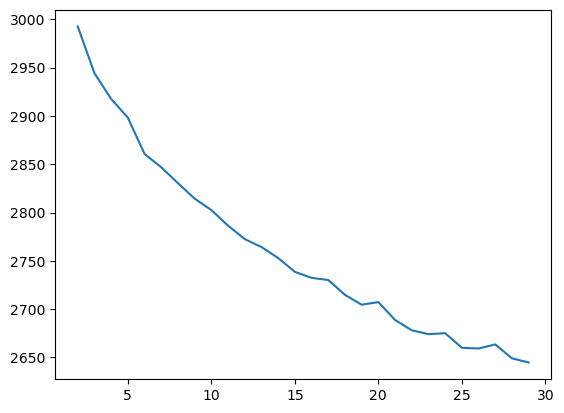

In [11]:
# kmeans clustering elbow plot
max_k = 3
sse = []
for k in range(2, max_k):
    clustering_model = KMeans(n_clusters=k)
    clustering_model.fit(embeddings)
    sse.append(clustering_model.inertia_)

plt.plot(range(2, max_k), sse)

In [17]:
num_clusters = 13
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(embeddings)
cluster_assignment = clustering_model.labels_

In [16]:
tsne_model = TSNE(n_components=2, perplexity=15)
tsne_values = tsne_model.fit_transform(embeddings)

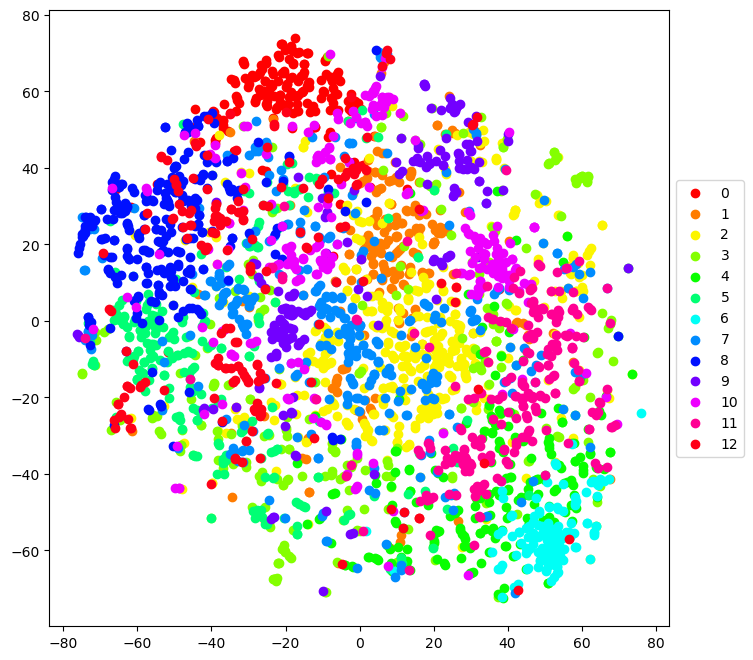

In [17]:
# plot tsne values with cluster coloring

colors = plt.cm.hsv(np.linspace(0, 1, num_clusters))

fig, ax = plt.subplots(figsize=(10, 8))

for i in range(num_clusters):
    ax.scatter(tsne_values[cluster_assignment == i, 0], tsne_values[cluster_assignment == i, 1], 
                c=[colors[i]], label=i)

# put the legend outside the plot
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

## Examine cluster centers with FAISS

In [19]:
cluster_centers = clustering_model.cluster_centers_
cluster_centers.shape

(13, 384)

In [18]:
d = embeddings.shape[1]
index = faiss.IndexFlatL2(d)
index.add(embeddings)

In [25]:
# look up the 5 nearest neighbors of first cluster
k = 5
c = 10
D, I = index.search(cluster_centers[c:c+1,:], k)

# show the corresponding comments
comm_df_trim.iloc[I.flatten()]

,user,body,utc,date
2448852,mk_gecko,OK. I was not completely accurate: the two or ...,1195997203,2007-11-25 13:26:43
2429407,modestokun,Well this article isn't the first of its kind ...,1195804408,2007-11-23 07:53:28
1459921,mk_gecko,Dumb article. Few facts to back it up. Just ma...,1186837835,2007-08-11 13:10:35
1427028,mk_gecko,Take a look around. Do you see any others? Tha...,1186445627,2007-08-07 00:13:47
1262064,mk_gecko,Wow! Great article. Very informative. I don't ...,1184291358,2007-07-13 01:49:18


## Examine clusters with Ollama

In [20]:
def ollama(prompt, model='llama3.1'):
    # Set up the endpoint and headers
    url = "http://localhost:11434/api/chat"
    
    # Define your payload
    data = {
        "model": model,
        "messages": [{
            "role": "system",
            "content": "You are a bot that summarizes text in a succinct, non-conversational way."
        }, {
            "role": "user",
            "content": prompt
        }],
        "stream": False
    }

    # Make the POST request
    response = requests.post(url, data=json.dumps(data))

    # Check for a successful response
    if response.status_code == 200:
        # Parse the JSON response
        completion = response.json()
        return completion['message']['content'].strip()
    else:
        print(f"Request failed with status code {response.status_code}")

In [17]:
# check sizes of each cluster
cluster_sizes = pd.Series(cluster_assignment).value_counts().sort_index()
print(cluster_sizes)

0     236
1     427
2     216
3     190
4     192
5     188
6     382
7     144
8     188
9     337
10    174
11    317
12    252
Name: count, dtype: int64


In [21]:
# loop through each cluster and create a summary of the sentences in it
base_prompt = "Summarize the following related set of comments \
    (where each comment is delimited by <comment></comment> tags).  \
    If the comments are unrelated, please indicate that. \
    Be concise and limit your response to 1-2 sentences. \
    Do not offer more assistance."

with open('clusters.out', 'w') as f:
    for i in range(num_clusters):
        print(f'Cluster {i}')

        # get sample of comments in this cluster
        cluster = comm_df_trim[cluster_assignment == i].sample(50, random_state=0)
        
        prompt = base_prompt
        for c in cluster['body'].values:
            prompt += f'<comment>{c}</comment>'
        
        response = ollama(prompt)

        # write response to file
        f.write(f'Cluster {i}\n')
        f.write(f'Summary: {response}\n\n')

Cluster 0
Cluster 1
Cluster 2
Cluster 3
Cluster 4
Cluster 5
Cluster 6
Cluster 7
Cluster 8
Cluster 9
Cluster 10
Cluster 11
Cluster 12


In [26]:
comm_df_trim[cluster_assignment == 3].sample(50, random_state=0)['body'].values

array(["Satan is killing these birds to test our faith in God.\r\n\r\n(It doesn't have to make sense, you just accept it as fact.)",
       'God actually put that "old" dinosaur there to test our faith.',
       'I am sorry if I creeped you out. I agree that you do not need religion to "help and love." Like I have tried to say in other replies, I was not trying to say that mine is the one true religion, there is no way that anybody can know that for sure. I was trying to express my personal beliefs, while agreeing with what the author of the article had to say. I have to get better at this whole commenting thing!',
       "Anyone who says that killing and Christianity are compatible isn't a Christian and has perverted the message of Jesus Christ. (If they're making references to the Old Testament though, I haven't a leg to stand on cos that's some seriously fucked up shit.)\r\n\r\n// Agnostic, raised Catholic.",
       'In all the others you have to work for salvation.\r\n\r\nIn (most)

/local/scr/stmorse/TMPDIR/ipykernel_2192090/4028055337.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(tsne_values[user_idx, 0], tsne_values[user_idx, 1],


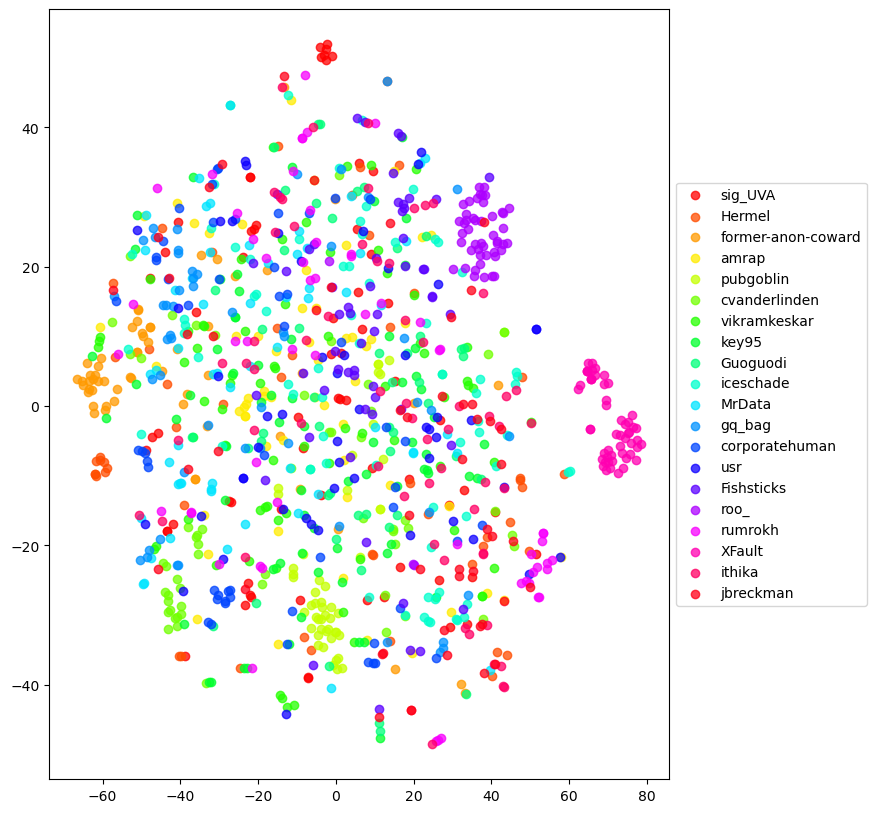

In [34]:
# convert user to color index for plotting
# user_color = list(comm_df_trim['user'].astype('category').cat.codes)

# get 10 colors for 10 users
cs = ['k', 'r', 'g', 'b', 'c', 'm', 'y', 'orange', 'purple', 'brown']

# get n unique colors for n users in comm_df_trim
colors = plt.cm.hsv(np.linspace(0, 1, len(user_trim['user'].unique())))

# save dict with color_index: user
# color_user = dict(zip(user_color, comm_df_trim['user']))


# plot
fig, ax = plt.subplots(figsize=(10, 10))

for k, user in enumerate(user_trim['user'].unique()):
    user_idx = np.where(comm_df_trim['user'] == user)[0]
    ax.scatter(tsne_values[user_idx, 0], tsne_values[user_idx, 1], 
            #    c=cs[k], label=user, alpha=0.75)
                c=colors[k], label=user, alpha=0.75)

# ax.scatter(tsne_values[:, 0], tsne_values[:, 1], c=user_color, cmap='hsv', alpha=0.5)

# Put the legend outside the plot
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.legend()
plt.show()

# Minibatching

In [26]:
comm_df.head()

,user,body,utc,date
0,jh99,early 2006 a probable date,1136074029,2006-01-01 00:07:09
1,jpb,If you are going to post something that has a ...,1136076410,2006-01-01 00:46:50
2,Pichu0102,Microsoft hates it's own products?\r\nWho knew?,1136078623,2006-01-01 01:23:43
3,libertas,"this looks interesting, but it's already aired...",1136079346,2006-01-01 01:35:46
4,mdmurray,I have nothing but good things to say about De...,1136081389,2006-01-01 02:09:49


In [28]:
# Initialize the model and the MiniBatchKMeans
model = SentenceTransformer('all-MiniLM-L6-v2')
batch_size = 1000
num_clusters = 13
kmeans = MiniBatchKMeans(n_clusters=num_clusters, batch_size=batch_size)

# Initialize a list to store batch embeddings
all_embeddings = []

# Process the comments in batches
k = 0
for start in range(0, len(comm_df), batch_size):
    print(f'Batch {k}')
    end = min(start + batch_size, len(comm_df))
    batch_comments = comm_df['body'].iloc[start:end].values
    batch_embeddings = model.encode(batch_comments, show_progress_bar=True)
    all_embeddings.append(batch_embeddings)
    kmeans.partial_fit(batch_embeddings)
    k += 1
    if k == 2:
        break

# Concatenate all batch embeddings
all_embeddings = np.vstack(all_embeddings)

# Fit the MiniBatchKMeans model
cluster_assignments = kmeans.predict(all_embeddings)

# Add the cluster assignments to the DataFrame
comm_df['cluster'] = cluster_assignments

Batch 0


Batches: 100%|██████████| 32/32 [01:02<00:00,  1.96s/it]


Batch 1


Batches: 100%|██████████| 32/32 [01:01<00:00,  1.91s/it]


ValueError: Length of values (2000) does not match length of index (2880743)

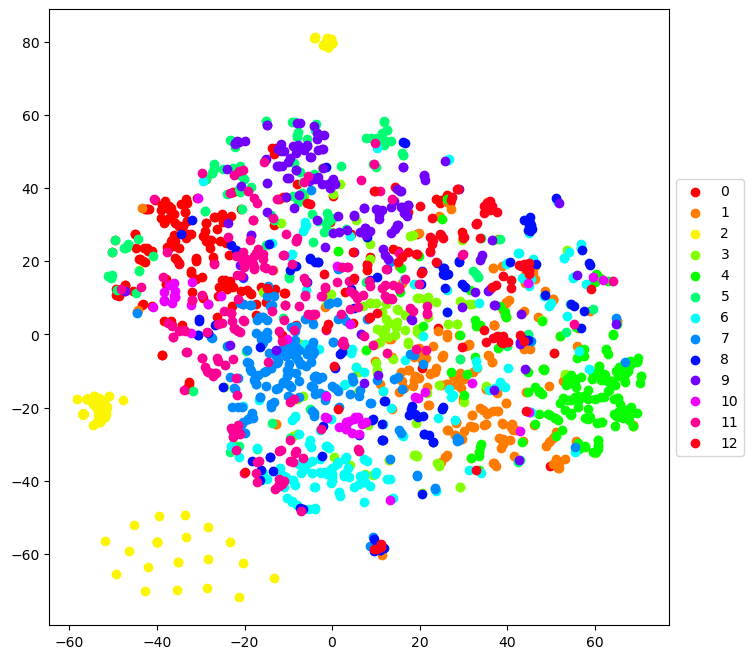

In [29]:
tsne_model = TSNE(n_components=2, perplexity=15)
tsne_values = tsne_model.fit_transform(all_embeddings)

colors = plt.cm.hsv(np.linspace(0, 1, num_clusters))

fig, ax = plt.subplots(figsize=(10, 8))

for i in range(num_clusters):
    ax.scatter(tsne_values[cluster_assignments == i, 0], tsne_values[cluster_assignments == i, 1], 
                c=[colors[i]], label=i)

# put the legend outside the plot
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [31]:
kmeans.cluster_centers_.shape

(13, 384)

In [30]:
d = all_embeddings.shape[1]
index = faiss.IndexFlatL2(d)
index.add(all_embeddings)

In [33]:
# look up the 5 nearest neighbors of first cluster
k = 5
c = 4
D, I = index.search(kmeans.cluster_centers_[c:c+1,:], k)

# show the corresponding comments
comm_df.iloc[I.flatten()]

,user,body,utc,date
883,AaronSw,"1. I was summarizing the article (""I'm not the...",1136586298,2006-01-06 22:24:58
919,TronXD,1. It *is* evangelism - of course it is. Putti...,1136616046,2006-01-07 06:40:46
948,AaronSw,"1. What non-religious group of evangelists ""pu...",1136649123,2006-01-07 15:52:03
1942,mnemonicsloth,One of my phil professors had an interesting t...,1137046531,2006-01-12 06:15:31
1593,[deleted],&gt; Paragraph 1: 'I believe in Christ because...,1136939128,2006-01-11 00:25:28


# Example users

In [14]:
sentences = comm_df.query('user == "sixstrings"')['body'].values
sentence_embeddings = model.encode(sentences)

In [9]:
sentences2 = comm_df.query('user == "yuubi"')['body'].values
sentence_embeddings2 = model.encode(sentences2)

In [15]:
sjoin = np.concatenate([sentence_embeddings, sentence_embeddings2], axis=0)
print(sjoin.shape)

(100, 768)


In [21]:
tsne = TSNE(n_components=2, metric='cosine', perplexity=15)
em = tsne.fit_transform(sjoin)

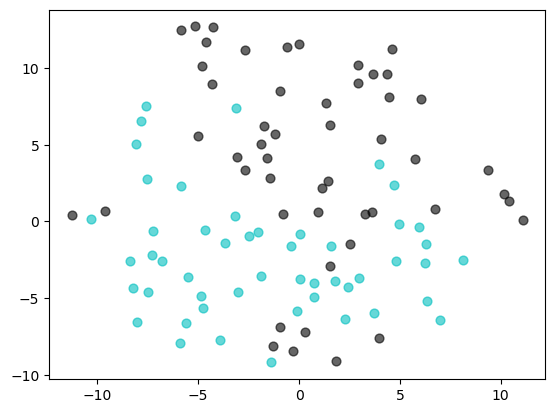

In [22]:
plt.scatter(em[:50, 0], em[:50, 1], s=40, c='c', alpha=0.6)
plt.scatter(em[50:, 0], em[50:, 1], s=40, c='k', alpha=0.6)
# plt.scatter(em2[:, 0], em2[:, 1], s=40, c='g', alpha=0.6)

In [32]:
d = sentence_embeddings.shape[1]
d

768

In [33]:
index = faiss.IndexFlatL2(d)
index.is_trained

True

In [34]:
index.add(sentence_embeddings)
index.ntotal

23

In [35]:
sentences

array(["this looks interesting, but it's already aired, and it's not like there's streaming video, so what's the point?",
       "oh my god. i loathe this kind of hit-you-over-the-head style preaching. it doesn't even give any details on how drunk the driver was, etc. if this becomes a hit on reddit i'm going to be pissed.",
       "for those of you wondering, the website he's talking about is http://www.world-tracker.com/. It only works in the UK for now, though the website says they have plans of extending the service to the US.",
       "Aww, look at them, they're making a Difference. I hear the legislature instantly convened an emergency session to raise the speed limits. Who says self-righteousness isn't effective?",
       "Exactly. You know, I notice that I've never read any of this so-called questionable content. And why is this? Because I, like all the other at least partially intelligent people, use information evaluating and filtering methods - like reddit and other link sit

In [21]:
xq = model.encode(['I love Connecticut!'])
D, I = index.search(xq, 3)
print(D, I)

[[199.15042 251.80487 276.62003]] [[ 5 11 20]]


In [22]:
sentences[I[0]]

array(['Wow, my feature request came true. Awesome.',
       "This is incredible. It's a satire of itself. Awesome.",
       'It blew my mind that Connecticut is spelled the way it is. Shit. How did I manage to go through life without knowing how to spell Connecticut?'],
      dtype=object)